<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/BT_MNIST_new2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

!pip install pytest
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 8.6 kB/s 
     |████████████████████████████████| 21.0 MB 269 kB/s 
     |████████████████████████████████| 2.9 MB 92.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [2]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [3]:
import fastai
import self_supervised
import torch
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3

In [4]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
#from Base_Stein.SVGD_classes import *

In [5]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [6]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [7]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [ ]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [ ]:
def random_polynomial(A):
    
    #B=torch.normal(mean=0, std=0.025, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    #Btem = torch.normal(mean=0,std=0.05, size=(1, 1)).item() #Sample coefficient of x^3
    #B = Btem + B*A #Third Horner term
    
    B = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    
#     Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
#     B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x
    #Btem=1
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [ ]:
def random_polynomial_bestsofar(A):
    
    
    B=torch.normal(mean=0, std=0.025, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    Btem = torch.normal(mean=0,std=0.05, size=(1, 1)).item() #Sample coefficient of x^3
    B = Btem + B*A #Third Horner term
    
    Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=1,std=2, size=(1, 1)).item() #Sample coefficient of x
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [ ]:
def low_deg(A):
    power=Unif(1,1.25)
    coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
    coeff1 = torch.normal(mean=1, std=1, size=(1, 1)).item() #degree 2 term
    
#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=1, std=0.7, size=(1, 1)).item() #degree 2 term

#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term

    
    B = (coeff1*A + coeff2*torch.abs(A).pow(power))
    
    #B = (1/power)*torch.abs(A).pow(power)
    return B

In [ ]:
def random_quintic(A):

    
    B=torch.normal(mean=0, std=0.125, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    
    Btem=torch.normal(mean=0, std=0.25, size=(1, 1)).item()#Sample coefficient of x^3
    B = Btem + B*A #Second Horner term
    
    Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=1,std=2, size=(1, 1)).item() #Sample coefficient of x
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B

In [49]:
def random_sinusoid(x,std=0.15,seed=0):

    seed_everything(seed=seed)
    
    t=torch.normal(mean=0,std=std,size=(1,1)).item()
    s=torch.normal(mean=0,std=std,size=(1,1)).item()
    
    u=torch.normal(mean=0,std=1,size=(1,1)).item()
    v=torch.normal(mean=0,std=1,size=(1,1)).item()
    
    a=torch.normal(mean=0,std=1,size=(1,1)).item()
    b=torch.normal(mean=0,std=1,size=(1,1)).item()
    
    return torch.sin(t*math.pi*x+u) + torch.cos(s*math.pi*x + v)

In [ ]:
def poly_sinusoid(x):
    
    return (x) + 0.2*random_sinusoid(x,std=(0.5))

In [9]:
def Exp_sample(scale=3.,loc=1.8):
    
    Expo = torch.distributions.exponential.Exponential
    E = Expo(torch.tensor([scale]))
#     if random.random()<0.5:
#         return 1
#     else:
    return loc+E.sample().item()

In [140]:
np.random.randint(0,1000)

471

In [10]:
def p_norm(x,p):

    eps=1e-8
    if p<1:
        x=x+eps
    return (1/p)*torch.abs(x).pow(p)

In [59]:
def update_seed(seed,epoch,index):

    if index%4: 
        return epoch+seed

    

In [188]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):

        if self.index%4 == 0: #every fourth index update the seed (best we have found so far)

            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1

        self.update_seed()

        
        #Uncomment to run standard BT
    # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
    #     bs,nf = pred.size(0)//2,pred.size(1)

    #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
    #     C = (z1norm.T @ z2norm) / bs 
    #     cdiff = (C - self.I)**2
    #     loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
    #     return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2

        #{'Pr': 0.45546983480453496, 'dist': 'Exp', 'loc': 0.49445648193359376, 'scale': 2.5828861594200134, 'percent_correct': 0.8277832269668579} #Best so far

        #self.update_seed()

        #input('hi')

        #polyprob=0.1
        #polyprob=0.45546
        #polyprob=1.0
        polyprob=1.0
        temrand = random.random()
        if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

            K=10
            cdiff_2=0
            for i in range(K):
            #p=Exp_sample(loc=1.5,scale=2.0)
            # #p=Unif(1.0,2.5)
                z1norm_2 = random_sinusoid(z1norm,seed=self.seed+i)
                z2norm_2 = z2norm
                C_2 = (z1norm_2.T @ z2norm_2) / bs
                #cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
                cdiff_2 = cdiff_2 + (C_2)**2
            
            cdiff_2=(1/K)*cdiff_2

            #symmetrize loss - so copy paste above block but swap place of 1 and 2
            #p=Exp_sample(loc=1.5,scale=2.0)
            #p=Unif(1.0,2.5)
            
            cdiff_2_sym=0
            for i in range(K):
                z1norm_2 = z1norm
                z2norm_2 = random_sinusoid(z2norm,seed=2*self.seed+i)

                C_2_sym = (z1norm_2.T @ z2norm_2) / bs
                cdiff_2_sym = cdiff_2_sym + C_2_sym**2
            
            cdiff_2_sym=(1/K)*cdiff_2_sym

            cdiff_2 = 0.5*cdiff_2 + 0.5*cdiff_2_sym #Symmetrized random loss

            cdiff_2 = 0.2*cdiff +  0.8*cdiff_2 #convex comb of BT loss with random loss -> assumes polyprob=1.0
            
        else:
            cdiff_2 = cdiff
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum() 
        return loss


    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [ ]:
#opt_func = partial(RMSProp, mom=0.9)


In [189]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwRMSProp(model.parameters(),lr=0.1, mom=0.9)ins(aug_pipelines, print_augs=True)])
opt = torch.optim.RMSprop
#partial(OptimWrapper, opt=opt)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
#learn = Learner(dls, model,opt_func=opt_func, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])



learn.fit(100) #300                            

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,83.119751,None,00:06
1,62.040192,None,00:06
2,53.689972,None,00:06
3,45.603691,None,00:06
4,37.645702,None,00:07
5,31.377258,None,00:06
6,26.378590,None,00:06
7,23.697859,None,00:06
8,23.641733,None,00:07
9,21.895990,None,00:06


In [12]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,tune_s=1000):
    
  
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(20)))

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=20, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    
    return dls_tune

 

In [13]:
#TODO: Do this in a slicker way. Write more tests 
#Get the dataloader and set batch size 
ts=16384 #training set size - most everything
bs=512
device='cuda'
path = untar_data(URLs.MNIST)

items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort() 

seed=42
seed_everything(seed=seed)
labeller = using_attr(RegexLabeller(pat = r'(\d+).png$'), 'name') 

items=items.shuffle()
items1 = items[0:ts] #train on these guys

l=labeller(items1[0])
if seed is 42:
    print('assert passed')
    assert labeller(items1[0]) == '19825' #check that random seed is working

else:
    input('Careful! New random seed ~= 42. Is that ok?')

split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

tune_s=2000 #we choose 20 guys (randomly) out of 1000 to tune on
items0 = items[ts:ts+tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 
dls_tune=tune_set(items0,tune_s=tune_s)


#NB: Uncomment and compare in colab and kaggle
# for x,y in dls_tune.train:
#   print(x.mean())
#   input()
#   break

# for x,y in dls_tune.train:
#   print(x.mean())
#   input()
#   break


#Evaluate linear classifier on this guy
test_bs=578
items2 = items[ts+tune_s:]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
tds_test = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=test_bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#Check that test_bs divides length of test set
tem=len(dls_test.train_ds)/test_bs
assert tem-math.floor(tem) == 0

assert passed


In [ ]:
test_bs=578


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


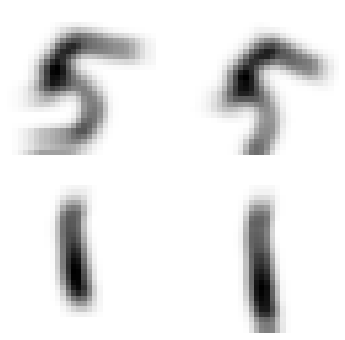

In [ ]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

<function fastai.optimizer.SGD(params, lr, mom=0.0, wd=0.0, decouple_wd=True)>

In [18]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [40]:
#NB: Will give same random 20-tune set (for fixed random seed), only if the cell
#"#Get the dataloader and set batch size" is the same. Perhaps later we can make this cell a function of that one. 
#Functions to train and evaluate head
fastai_encoder.eval()

def train_head(seed=10): #The seed choses a different (20) samples for training the head. 2 of each class

    seed_everything(seed=seed)
    dls_tune=tune_set(items0,tune_s=tune_s) #different random tune set each time (but random seed same for consistency)
  
    zdim=1024 #see above
    head = LinearClassifier(zdim=zdim)
    device='cuda'
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    #EPOCHS=100

    for epoch in range(200):

        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20
  
        loss = criterion(head(fastai_encoder(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)

    return head


def eval_head(head):

    N=len(dls_test.train)*test_bs #close to len(dls_test.train_ds) but not quite...

    assert N == len(dls_test.train_ds)

    num_correct=0

    for x,y in dls_test.train:
    #for i in range(3):

        ypred = head(fastai_encoder(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N





In [190]:
%%time
seed=10
performance_dict={}
for num in range(5):

    head=train_head(seed=seed+num)
    pct_correct = eval_head(head)

    performance_dict[f'seed_{num}'] = pct_correct 

print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict

{'seed_0': TensorCategory(0.8221), 'seed_1': TensorCategory(0.7424), 'seed_2': TensorCategory(0.8724), 'seed_3': TensorCategory(0.8159), 'seed_4': TensorCategory(0.8162)}
tensor(0.8138)
CPU times: user 40.7 s, sys: 3.79 s, total: 44.5 s
Wall time: 1min 22s


In [192]:
#To beat: 0.7756. All we changed is batch size random function
print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict


tensor(0.8138)


{'seed_0': TensorCategory(0.8221),
 'seed_1': TensorCategory(0.7424),
 'seed_2': TensorCategory(0.8724),
 'seed_3': TensorCategory(0.8159),
 'seed_4': TensorCategory(0.8162)}

In [193]:
#100 learn_epochs, new baseline!
sinu={'seed_0': TensorCategory(0.8221),
 'seed_1': TensorCategory(0.7424),
 'seed_2': TensorCategory(0.8724),
 'seed_3': TensorCategory(0.8159),
 'seed_4': TensorCategory(0.8162)}
print(torch.mean(tensor(list(sinu.values())))) #tensor(0.8138)


#100 learn_epochs, baseline for BT
Baseline_BT = {'seed_0': TensorCategory(0.7621),
 'seed_1': TensorCategory(0.7099),
 'seed_2': TensorCategory(0.8630),
 'seed_3': TensorCategory(0.7644),
 'seed_4': TensorCategory(0.7367)}

print(torch.mean(tensor(list(Baseline_BT.values())))) #tensor(0.7672)


tensor(0.8138)
tensor(0.7672)


tensor(0.8487)

In [ ]:
performance_dict

NameError: ignored